In [1]:

import tensorflow as tf
print(tf.__version__)


/Users/chidam_sp/codify_odi/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.14.0


In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gc
import csv
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [4]:

df = pd.read_csv("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv")


In [5]:

df.head()


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [6]:

len(df)


3650

In [19]:

3650//4


912

In [4]:

def raw_data_to_input(data_source):
    time_step = []
    temps = []
    
    with open(data_source) as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      next(reader)
      step = 0
      for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1
    
    series = np.array(temps)
    time = np.array(time_step)
    return series, time


In [279]:
del series, time, time_train, x_train, time_test, x_test

In [5]:

series, time = raw_data_to_input("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv")


In [6]:

series


array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [7]:

time


array([   0,    1,    2, ..., 3647, 3648, 3649])

In [8]:

def split_train_test(split_time):

    # Get the train set 
    time_train = time[:split_time]
    x_train = series[:split_time]
    
    # Get the test set and keep it away to validate, only once, the final model's performance  
    time_test = time[split_time:]
    x_test = series[split_time:]

    return time_train, x_train, time_test, x_test



In [9]:

time_train, x_train, time_test, x_test = split_train_test(3400)


In [10]:

x_train


array([20.7, 17.9, 18.8, ..., 11.2, 12.7, 13.7])

In [11]:

time_train


array([   0,    1,    2, ..., 3397, 3398, 3399])

In [14]:

len(x_train)


3400

In [15]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer=False):
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) ##the None dimension invoked by window.batch is 
    ##of course necessary 

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    if shuffle_buffer:
        # # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer)
    
    # # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
        
    return dataset



In [258]:

def model_build():
    tf.random.set_seed(51)
    np.random.seed(51)
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    return model



In [120]:

# def scheduler(epoch, lr):
#   if epoch < 10:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)


In [259]:

def cv_loop(n_splits, series, lr_schedule, window_size, batch_size, train_shuffle):

    entire_history = {}

    tscv = TimeSeriesSplit(n_splits)


    for fold, (train_index, val_index) in enumerate(tscv.split(series)):
        tf.keras.backend.clear_session()
        train_series, val_series = series[train_index], series[val_index]
    
        # Apply your windowed_dataset function to create TF datasets
        train_dataset = windowed_dataset(train_series, window_size, batch_size, train_shuffle)
        val_dataset = windowed_dataset(val_series, window_size, batch_size, shuffle_buffer=False)  # Note: Might not need to shuffle the test/validation set
        
        # Example model training and evaluation
        model = model_build()  # Function to create your model
    
        history = model.fit(train_dataset, epochs=20, callbacks=[lr_schedule], validation_data=val_dataset, verbose=1)
        entire_history[f"fold_{fold+1}"] = history.history
        
    
    return entire_history


In [196]:

def custom_lr_schedule(epoch):
    # Parameters for the learning rate schedule
    initial_lr = 1e-5
    max_lr = 1e-3
    increase_epochs = 10  # Epochs until which to increase the learning rate
    decrease_factor = 0.05  # Factor to decrease the learning rate after peak
    
    if epoch < increase_epochs:
        # Linearly increase the learning rate
        lr = initial_lr + (max_lr - initial_lr) / increase_epochs * epoch
    else:
        # Decrease the learning rate exponentially after hitting the peak
        lr = max_lr * (decrease_factor ** (epoch - increase_epochs))
    return lr


In [197]:
del custom_lr_schedule

In [278]:

del cv_loop, window_size, batch_size, n_splits, lr_schedule
gc.collect()


149949

In [253]:
del history

In [260]:

window_size = 30
batch_size = 32
n_splits = 3
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(custom_lr_schedule)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))

# initial_learning_rate = 1e-3
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=55,
#     decay_rate=0.95,
#     staircase=False)# Set to False for smooth decay, True for stepwise decay

# # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=decay_steps,
#     decay_rate=decay_rate,
#     staircase=True  
# )



In [261]:

history = cv_loop(n_splits, x_train, lr_schedule, window_size, batch_size, train_shuffle=1000)


Epoch 1/20
     26/Unknown - 14s 338ms/step - loss: 8.9394 - mae: 9.4314

2024-03-20 18:09:51.136132: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16772905303467291389
2024-03-20 18:09:51.136154: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3858962217706101676
2024-03-20 18:09:51.136160: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17296771002965660491
2024-03-20 18:09:51.136165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13063187173193655940


26/26 [==============================] - 18s 486ms/step - loss: 8.9394 - mae: 9.4314 - val_loss: 3.2464 - val_mae: 3.7165 - lr: 1.0000e-06
Epoch 2/20


2024-03-20 18:09:54.827550: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16448991285192849824
2024-03-20 18:09:54.827569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1964503087893029434
2024-03-20 18:09:54.827592: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17621190702863008526
2024-03-20 18:09:54.827595: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14465948264916792491
2024-03-20 18:09:54.827617: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7061804332302320800


26/26 [==============================] - 4s 148ms/step - loss: 3.1586 - mae: 3.6265 - val_loss: 2.5330 - val_mae: 2.9959 - lr: 1.0513e-06
Epoch 3/20
26/26 [==============================] - 2s 77ms/step - loss: 2.7313 - mae: 3.1902 - val_loss: 2.5284 - val_mae: 2.9926 - lr: 1.1052e-06
Epoch 4/20
26/26 [==============================] - 2s 64ms/step - loss: 2.6736 - mae: 3.1309 - val_loss: 2.4755 - val_mae: 2.9373 - lr: 1.1618e-06
Epoch 5/20
26/26 [==============================] - 1s 56ms/step - loss: 2.6390 - mae: 3.0985 - val_loss: 2.4436 - val_mae: 2.9035 - lr: 1.2214e-06
Epoch 6/20
26/26 [==============================] - 2s 68ms/step - loss: 2.6026 - mae: 3.0663 - val_loss: 2.4415 - val_mae: 2.9008 - lr: 1.2840e-06
Epoch 7/20
26/26 [==============================] - 2s 61ms/step - loss: 2.5844 - mae: 3.0438 - val_loss: 2.3941 - val_mae: 2.8524 - lr: 1.3499e-06
Epoch 8/20
26/26 [==============================] - 2s 61ms/step - loss: 2.5552 - mae: 3.0145 - val_loss: 2.3841 - val_mae

2024-03-20 18:10:43.115461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3858962217706101676
2024-03-20 18:10:43.115484: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16772905303467291389
2024-03-20 18:10:43.115502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4938095535582090034
2024-03-20 18:10:43.115510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17296771002965660491
2024-03-20 18:10:43.115513: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13063187173193655940


53/53 [==============================] - 20s 261ms/step - loss: 10.4504 - mae: 10.9414 - val_loss: 6.8861 - val_mae: 7.3703 - lr: 1.0000e-06
Epoch 2/20


2024-03-20 18:10:46.991814: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16448991285192849824
2024-03-20 18:10:46.991836: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1964503087893029434
2024-03-20 18:10:46.991840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14465948264916792491
2024-03-20 18:10:46.991866: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17621190702863008526
2024-03-20 18:10:46.991889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7061804332302320800


53/53 [==============================] - 4s 72ms/step - loss: 7.2788 - mae: 7.7670 - val_loss: 4.7619 - val_mae: 5.2457 - lr: 1.0513e-06
Epoch 3/20
53/53 [==============================] - 3s 63ms/step - loss: 5.1158 - mae: 5.5989 - val_loss: 3.4271 - val_mae: 3.9015 - lr: 1.1052e-06
Epoch 4/20
53/53 [==============================] - 3s 49ms/step - loss: 3.7624 - mae: 4.2410 - val_loss: 2.5926 - val_mae: 3.0576 - lr: 1.1618e-06
Epoch 5/20
53/53 [==============================] - 3s 56ms/step - loss: 2.9304 - mae: 3.4006 - val_loss: 2.1917 - val_mae: 2.6490 - lr: 1.2214e-06
Epoch 6/20
53/53 [==============================] - 3s 65ms/step - loss: 2.4687 - mae: 2.9284 - val_loss: 1.9482 - val_mae: 2.4001 - lr: 1.2840e-06
Epoch 7/20
53/53 [==============================] - 3s 51ms/step - loss: 2.2657 - mae: 2.7256 - val_loss: 1.8791 - val_mae: 2.3357 - lr: 1.3499e-06
Epoch 8/20
53/53 [==============================] - 3s 47ms/step - loss: 2.1796 - mae: 2.6394 - val_loss: 1.8514 - val_mae:

2024-03-20 18:11:56.747525: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3858962217706101676
2024-03-20 18:11:56.747549: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4938095535582090034
2024-03-20 18:11:56.747568: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13063187173193655940
2024-03-20 18:11:56.747575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16772905303467291389
2024-03-20 18:11:56.747594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17296771002965660491
2024-03-20 18:11:56.747597: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13846971038722096285


79/79 [==============================] - 22s 201ms/step - loss: 19.1679 - mae: 19.6610 - val_loss: 4.5111 - val_mae: 4.9870 - lr: 1.0000e-06
Epoch 2/20
 1/79 [..............................] - ETA: 10s - loss: 4.2982 - mae: 4.7786

2024-03-20 18:12:00.725023: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6919418093241757808
2024-03-20 18:12:00.725042: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16448991285192849824
2024-03-20 18:12:00.725051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14465948264916792491
2024-03-20 18:12:00.725075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1964503087893029434
2024-03-20 18:12:00.725082: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17621190702863008526
2024-03-20 18:12:00.725090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7061804332302320800


79/79 [==============================] - 5s 64ms/step - loss: 3.1039 - mae: 3.5779 - val_loss: 3.2034 - val_mae: 3.6838 - lr: 1.0513e-06
Epoch 3/20
79/79 [==============================] - 4s 48ms/step - loss: 2.7083 - mae: 3.1782 - val_loss: 2.7888 - val_mae: 3.2634 - lr: 1.1052e-06
Epoch 4/20
79/79 [==============================] - 4s 46ms/step - loss: 2.4233 - mae: 2.8883 - val_loss: 2.3779 - val_mae: 2.8420 - lr: 1.1618e-06
Epoch 5/20
79/79 [==============================] - 4s 51ms/step - loss: 2.1673 - mae: 2.6297 - val_loss: 2.1383 - val_mae: 2.5958 - lr: 1.2214e-06
Epoch 6/20
79/79 [==============================] - 4s 45ms/step - loss: 1.9938 - mae: 2.4475 - val_loss: 1.9502 - val_mae: 2.4038 - lr: 1.2840e-06
Epoch 7/20
79/79 [==============================] - 3s 44ms/step - loss: 1.8886 - mae: 2.3406 - val_loss: 1.8387 - val_mae: 2.2906 - lr: 1.3499e-06
Epoch 8/20
79/79 [==============================] - 3s 43ms/step - loss: 1.8289 - mae: 2.2802 - val_loss: 1.7639 - val_mae:


## tf.keras.optimizers.legacy.SGD with its default parameters, no learning_rate, and batch_size = 16. Can see the loss and error are in larger ranges.


In [28]:

history


{'loss': [68.00096893310547,
  49.672828674316406,
  49.481239318847656,
  49.64316940307617,
  49.415992736816406,
  49.40534973144531,
  49.44123077392578,
  49.3370246887207,
  49.50930404663086,
  49.43070983886719],
 'mae': [68.5009765625,
  50.17280960083008,
  49.981239318847656,
  50.14316940307617,
  49.915992736816406,
  49.90534973144531,
  49.94123077392578,
  49.8370246887207,
  50.00930404663086,
  49.93070983886719],
 'val_loss': [12.333266258239746,
  13.877396583557129,
  13.936299324035645,
  13.862568855285645,
  13.783184051513672,
  13.830402374267578,
  13.716293334960938,
  13.785796165466309,
  13.859963417053223,
  13.806310653686523],
 'val_mae': [12.833266258239746,
  14.377396583557129,
  14.436300277709961,
  14.362568855285645,
  14.283183097839355,
  14.330403327941895,
  14.216294288635254,
  14.28579330444336,
  14.359963417053223,
  14.306310653686523]}

In [29]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([11, 70])
    plt.legend(loc='upper right')
    plt.show()


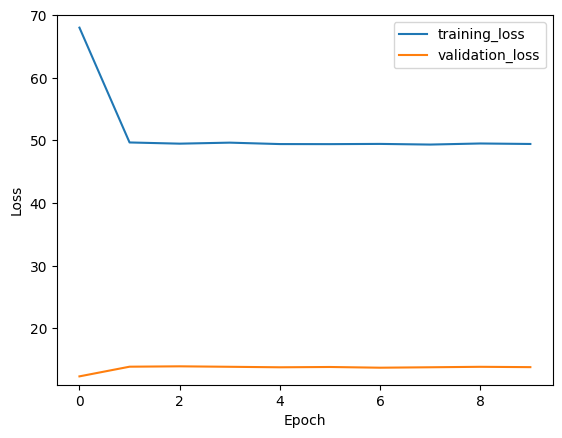

In [30]:

plot_learning_curve_loss(history)


In [32]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([11, 70])
    plt.legend(loc='upper right')


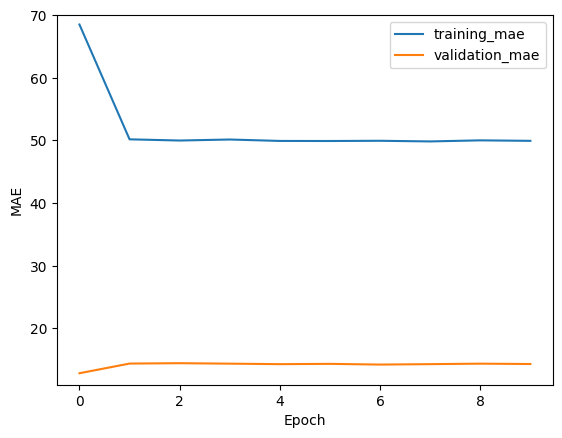

In [33]:

plot_learning_curve_metric(history)



## tf.keras.optimizers.legacy.SGD with its default parameters, no learning_rate, and batch_size = 32. I wanted to see how much impact the batch_size was having on the model's performance 



In [41]:

history


{'loss': [84.56954956054688,
  49.34825897216797,
  49.82574462890625,
  49.41764450073242,
  49.64604187011719,
  49.291107177734375,
  49.82321548461914,
  49.387393951416016,
  49.72559356689453,
  49.2353630065918],
 'mae': [85.06907653808594,
  49.84825897216797,
  50.32574462890625,
  49.91764450073242,
  50.14603805541992,
  49.791107177734375,
  50.32321548461914,
  49.887393951416016,
  50.225589752197266,
  49.7353630065918],
 'val_loss': [36.08637619018555,
  62.913185119628906,
  36.110504150390625,
  62.934078216552734,
  36.09235382080078,
  63.245079040527344,
  36.046199798583984,
  63.09184265136719,
  36.088680267333984,
  62.87873840332031],
 'val_mae': [36.58637619018555,
  63.413185119628906,
  36.610504150390625,
  63.434078216552734,
  36.59235382080078,
  63.74507522583008,
  36.546199798583984,
  63.59184265136719,
  36.588680267333984,
  63.37873840332031]}

In [77]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([35, 85])
    plt.legend(loc='upper right')
    plt.show()


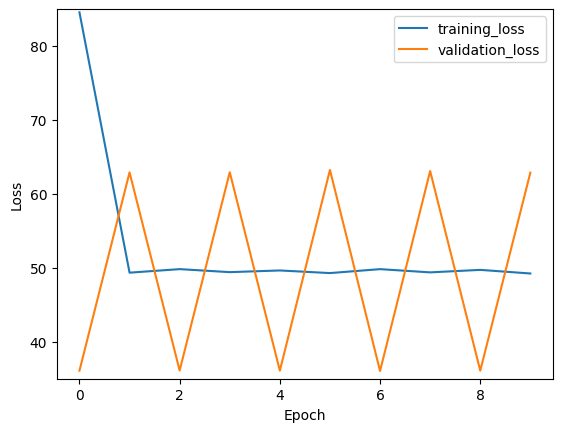

In [45]:

plot_learning_curve_loss(history)



## Observation
From the above plot: a plot looking like jagged teeth (in orange) is usually a batch_size problem.



In [54]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([36, 64])
    plt.legend(loc='upper right')


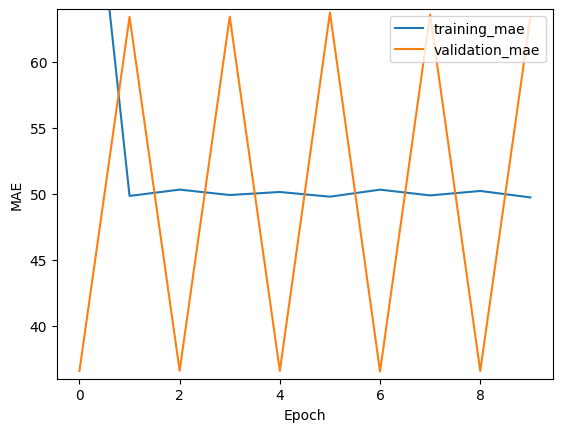

In [55]:

plot_learning_curve_metric(history)



## According to chatGPT

When the validation loss and error look like jagged teeth in the above plot, it could mean any of the following:
1. High Variability in Validation Performance
2. Overfitting
3. Learning Rate Issues
4. Insufficient Regularization
5. Batch Size Too Small

Strategies to Mitigate Jagged Validation Loss:
1. Adjust the Learning Rate
2. Implement Regularization
3. Revise the Model Architecture
4. Use Early Stopping
5. Experiment with Batch Sizes
6. Data Augmentation or Noise Reduction




## Let's add a fixed learning_rate, tf.keras.optimizers.legacy.SGD with its default parameters, and batch_size = 32. Can see the error and loss have been reduced significantly

window_size = 30
batch_size = 32
n_splits = 3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6)



In [75]:

history


{'loss': [47.193634033203125,
  30.18377113342285,
  14.718900680541992,
  5.692269325256348,
  4.530363082885742,
  4.33167839050293,
  4.192255973815918,
  4.052879810333252,
  3.9183707237243652,
  3.785142183303833],
 'mae': [47.693634033203125,
  30.683773040771484,
  15.216066360473633,
  6.174122333526611,
  5.014660358428955,
  4.813155174255371,
  4.673214435577393,
  4.532868385314941,
  4.398063659667969,
  4.263564586639404],
 'val_loss': [41.0764045715332,
  24.43840789794922,
  9.819866180419922,
  5.748332500457764,
  5.0894856452941895,
  4.898823261260986,
  4.701537132263184,
  4.556605339050293,
  4.38800573348999,
  4.260101318359375],
 'val_mae': [41.5764045715332,
  24.93840789794922,
  10.30777645111084,
  6.235311031341553,
  5.5752973556518555,
  5.382549285888672,
  5.185359477996826,
  5.041009902954102,
  4.872949123382568,
  4.743999004364014],
 'lr': [1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06]}

In [60]:
del plot_learning_curve_loss, plot_learning_curve_metric

In [79]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([3, 48])
    plt.legend(loc='upper right')
    plt.show()


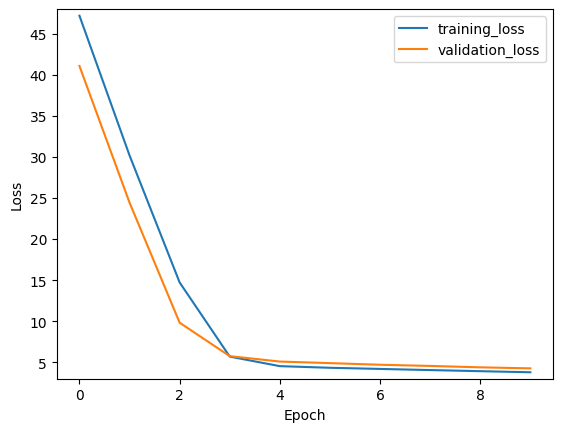

In [80]:

plot_learning_curve_loss(history)


In [81]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([4, 48])
    plt.legend(loc='upper right')


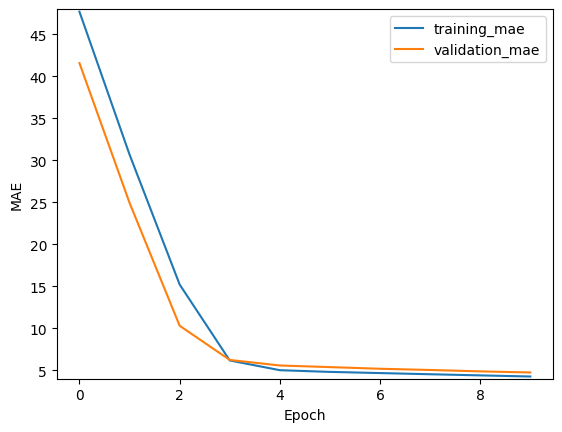

In [82]:

plot_learning_curve_metric(history)


## Some understanding re loss, metric, and optimizer

1. While most optimizers are generally compatible with any differentiable loss function, the choice of optimizer can affect the efficiency of training. For example, adaptive optimizers like Adam or RMSprop might converge faster or require less tuning of the learning rate compared to SGD in many scenarios.

2. Often, the best combination of loss function, metric, and optimizer emerges from empirical experimentation. It's common to start with standard choices (like MSE or MAE for regression problems with SGD or Adam as optimizers) and then iterate based on initial results.

3. Optimizers in machine learning algorithms are methods used to change the attributes of the neural network, such as weights and learning rate, to reduce losses. Optimizers aim to minimize (or maximize) a loss function by iteratively updating the model parameters.

4. tf.keras.optimizers.legacy.SGD refers to the Stochastic Gradient Descent optimizer, a legacy version of SGD in TensorFlow. It's one of the most basic optimization algorithms, which updates the model's weights based on the gradient of the loss function with respect to the weights.


In [29]:

del history



## With two LSTM layers with 32 nodes, flat learning_rate at 1e-6
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

window_size = 30
batch_size = 32
n_splits = 3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6)


In [92]:

history


{'loss': [11.851266860961914,
  4.89475679397583,
  4.320170879364014,
  4.016327381134033,
  3.789275646209717,
  3.603151798248291,
  3.4518349170684814,
  3.3315937519073486,
  3.244432210922241,
  3.185979127883911],
 'mae': [12.337005615234375,
  5.372844219207764,
  4.795699596405029,
  4.488778591156006,
  4.261325836181641,
  4.074550628662109,
  3.922631025314331,
  3.8015527725219727,
  3.71317982673645,
  3.655210256576538],
 'val_loss': [5.073254108428955,
  4.094395160675049,
  3.735795497894287,
  3.492490530014038,
  3.2872636318206787,
  3.1315572261810303,
  2.9911065101623535,
  2.8939738273620605,
  2.8334920406341553,
  2.79659366607666],
 'val_mae': [5.550314903259277,
  4.566222667694092,
  4.211165904998779,
  3.9712047576904297,
  3.761308193206787,
  3.600229501724243,
  3.455603837966919,
  3.3598406314849854,
  3.2998740673065186,
  3.263528347015381],
 'lr': [1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06]}

In [93]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([2, 12])
    plt.legend(loc='upper right')
    plt.show()


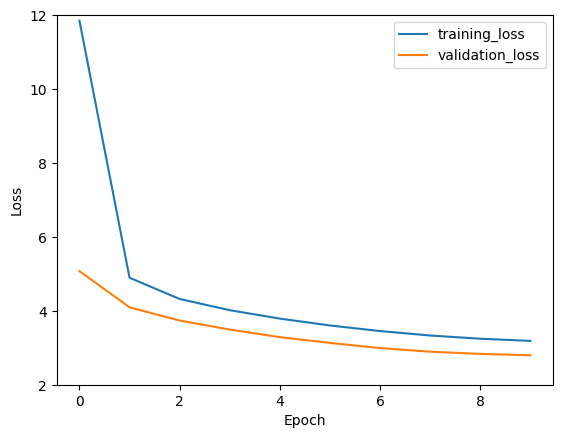

In [94]:

plot_learning_curve_loss(history)


In [95]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([3, 13])
    plt.legend(loc='upper right')



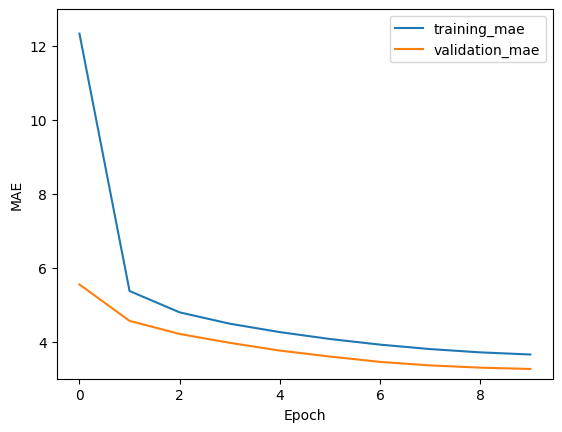

In [96]:

plot_learning_curve_metric(history)



## Changed the learning rate: lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10)). Can see a huge increment in the model's performance

window_size = 30
batch_size = 32
n_splits = 3


In [104]:

history


{'loss': [2.4394965171813965,
  2.1188721656799316,
  2.0751285552978516,
  2.0345377922058105,
  1.9943151473999023,
  1.9734249114990234,
  1.9522993564605713,
  1.9360618591308594,
  1.9290192127227783,
  1.9190826416015625],
 'mae': [2.8989713191986084,
  2.5735769271850586,
  2.5299432277679443,
  2.489185333251953,
  2.4478912353515625,
  2.4289498329162598,
  2.407334089279175,
  2.391352653503418,
  2.385166645050049,
  2.37394642829895],
 'val_loss': [1.995261311531067,
  1.9285926818847656,
  1.8824766874313354,
  1.856989860534668,
  1.8197320699691772,
  1.8263506889343262,
  1.7790520191192627,
  1.7969200611114502,
  1.7550957202911377,
  1.7492589950561523],
 'val_mae': [2.4539337158203125,
  2.3809590339660645,
  2.331644296646118,
  2.3087568283081055,
  2.2675561904907227,
  2.2761788368225098,
  2.224307060241699,
  2.2483468055725098,
  2.1999752521514893,
  2.1952056884765625],
 'lr': [1e-06,
  1.1051709e-06,
  1.2214026e-06,
  1.3498587e-06,
  1.4918246e-06,
  1.6

In [109]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1.7, 2.5])
    plt.legend(loc='upper right')
    plt.show()


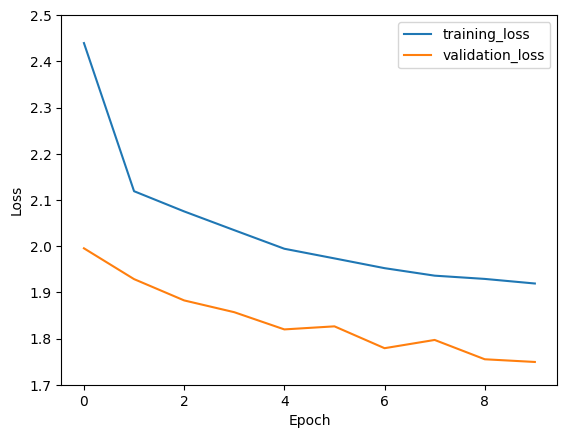

In [110]:

plot_learning_curve_loss(history)


In [114]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2.1, 3])
    plt.legend(loc='upper right')


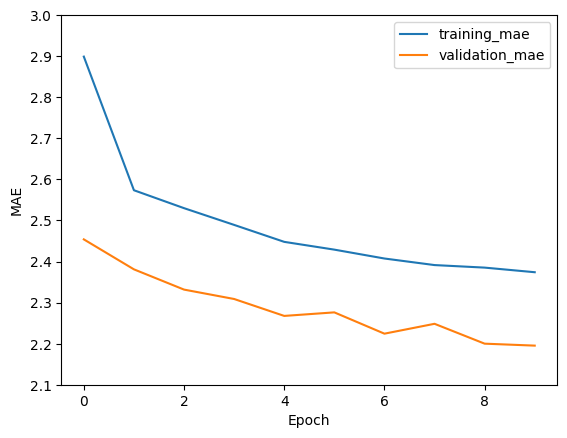

In [115]:

plot_learning_curve_metric(history)


In [125]:

history


{'loss': [12.218561172485352,
  2.769153356552124,
  2.4593846797943115,
  2.2376046180725098,
  2.077014923095703,
  1.9802350997924805,
  1.9214433431625366,
  1.8918821811676025,
  1.872320294380188,
  1.8609039783477783,
  1.8462392091751099,
  1.8449167013168335,
  1.8380173444747925,
  1.82705819606781,
  1.8072240352630615,
  1.804578185081482,
  1.794437289237976,
  1.7834221124649048,
  1.774619460105896,
  1.7769078016281128],
 'mae': [12.706568717956543,
  3.235214948654175,
  2.925264596939087,
  2.7007384300231934,
  2.5360209941864014,
  2.4372448921203613,
  2.377176284790039,
  2.3463857173919678,
  2.3255178928375244,
  2.3159821033477783,
  2.301405191421509,
  2.2982797622680664,
  2.2936155796051025,
  2.2819736003875732,
  2.2585434913635254,
  2.255880832672119,
  2.2467362880706787,
  2.235699415206909,
  2.22514009475708,
  2.228062152862549],
 'val_loss': [2.7927377223968506,
  2.4804203510284424,
  2.163466215133667,
  1.9812849760055542,
  1.871914029121399,


In [130]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1.5, 3])
    plt.legend(loc='upper right')
    plt.show()


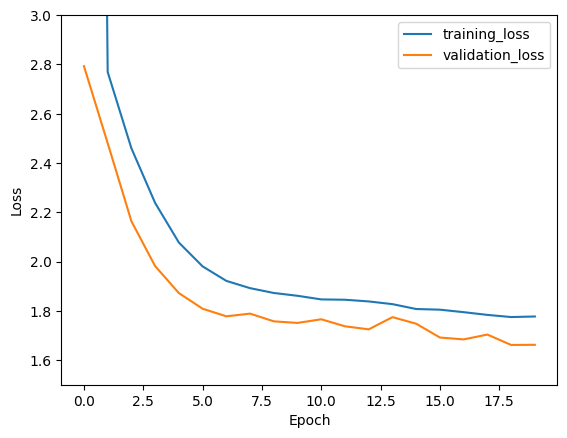

In [131]:
plot_learning_curve_loss(history)

In [138]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 3.5])
    plt.legend(loc='upper right')



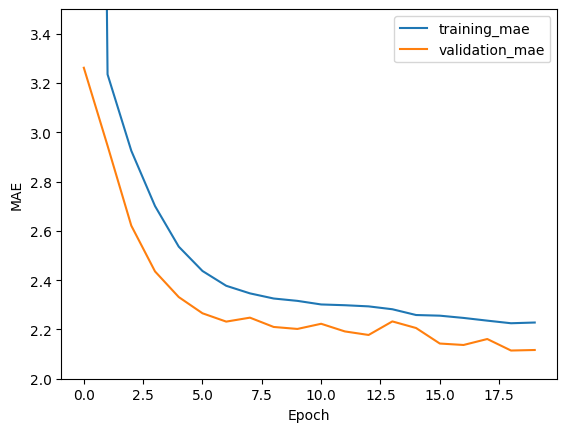

In [139]:
plot_learning_curve_metric(history)

In [143]:
del df
gc.collect()

0

In [144]:
from tensorflow.keras.backend import clear_session
clear_session()


## Having the following architecture and implementing a "stepwise ladder" learning rate schedule 

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD()
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

window_size = 30
batch_size = 32
n_splits = 3


In [24]:

history


{'loss': [3.318804979324341,
  8.912271499633789,
  9.179401397705078,
  7.5499773025512695,
  5.794933795928955,
  4.843013763427734,
  4.816331386566162,
  4.684183120727539,
  4.660390853881836,
  5.0913004875183105,
  5.256092071533203,
  1.8103994131088257,
  1.6848413944244385,
  1.6836804151535034,
  1.6836260557174683,
  1.6836241483688354,
  1.6836241483688354,
  1.6836243867874146,
  1.683624029159546,
  1.6836237907409668],
 'mae': [3.783252000808716,
  9.410057067871094,
  9.678428649902344,
  8.048247337341309,
  6.28759765625,
  5.334707260131836,
  5.308223724365234,
  5.175806045532227,
  5.149785041809082,
  5.584184169769287,
  5.749751567840576,
  2.2620182037353516,
  2.13569712638855,
  2.1345248222351074,
  2.134463310241699,
  2.1344616413116455,
  2.1344616413116455,
  2.1344611644744873,
  2.1344614028930664,
  2.134460926055908],
 'val_loss': [1.882416009902954,
  7.213046073913574,
  7.344733238220215,
  5.879653453826904,
  3.5550496578216553,
  3.8210828304

In [25]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 10])
    plt.legend(loc='upper right')
    plt.show()


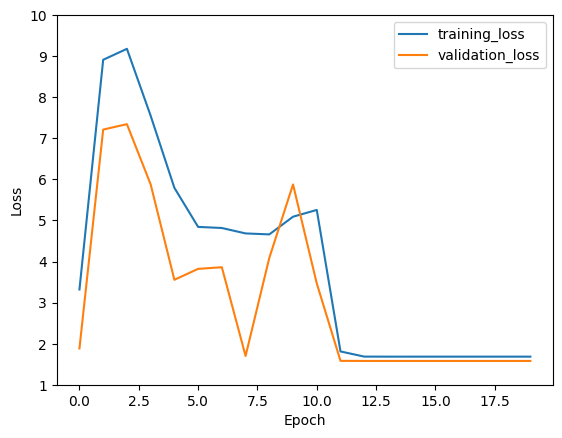

In [26]:

plot_learning_curve_loss(history)


In [27]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 10])
    plt.legend(loc='upper right')


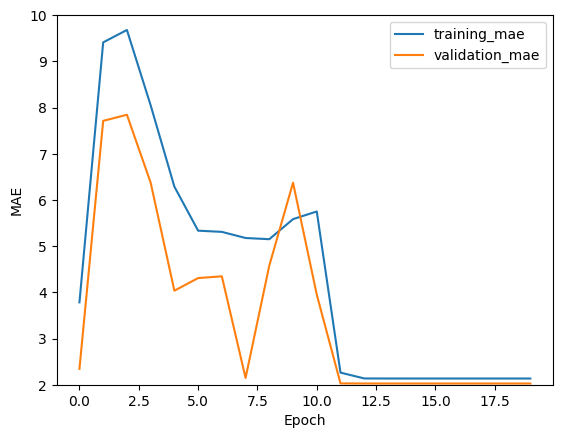

In [28]:

plot_learning_curve_metric(history)



## Observation about stepwise ladder approach for learning rate
It does not look like the stepwise ladder approach worked for this data type. We have experimented with the exponentially decreasing the learning rate and it seems to work so let's stick with that.


In [ ]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10))


In [35]:

for epoch in range(1, 10):
    print(1e-6 * tf.math.exp(epoch/10))



tf.Tensor(1.1051709e-06, shape=(), dtype=float32)
tf.Tensor(1.2214026e-06, shape=(), dtype=float32)
tf.Tensor(1.3498587e-06, shape=(), dtype=float32)
tf.Tensor(1.4918246e-06, shape=(), dtype=float32)
tf.Tensor(1.6487212e-06, shape=(), dtype=float32)
tf.Tensor(1.8221187e-06, shape=(), dtype=float32)
tf.Tensor(2.0137527e-06, shape=(), dtype=float32)
tf.Tensor(2.2255408e-06, shape=(), dtype=float32)
tf.Tensor(2.459603e-06, shape=(), dtype=float32)


In [41]:



for epoch in range(1, 10):
    print(1e-8 * -10**(epoch / 20))
    


-1.1220184543019634e-08
-1.2589254117941673e-08
-1.4125375446227544e-08
-1.5848931924611136e-08
-1.7782794100389228e-08
-1.9952623149688796e-08
-2.2387211385683395e-08
-2.51188643150958e-08
-2.8183829312644537e-08


In [40]:

for epoch in range(1, 10):
    print(1e-8 * 10**(epoch))


1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0



## using tf.keras.optimizers.schedules.ExponentialDecay
initial_learning_rate = 1e-6
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=0.005,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD()
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

window_size = 30
batch_size = 32
n_splits = 3


In [54]:

history


{'loss': [25.56448745727539,
  25.55957794189453,
  25.55958366394043,
  25.559581756591797,
  25.55958366394043,
  25.559579849243164,
  25.55958366394043,
  25.559581756591797,
  25.559581756591797,
  25.55958366394043,
  25.55958366394043,
  25.559589385986328,
  25.55957794189453,
  25.55958366394043,
  25.559585571289062,
  25.559581756591797,
  25.55958366394043,
  25.559574127197266,
  25.559587478637695,
  25.559579849243164],
 'mae': [26.064491271972656,
  26.0595760345459,
  26.059585571289062,
  26.05958366394043,
  26.05958366394043,
  26.059579849243164,
  26.05958366394043,
  26.059579849243164,
  26.059579849243164,
  26.059585571289062,
  26.059585571289062,
  26.059589385986328,
  26.059579849243164,
  26.05958366394043,
  26.059589385986328,
  26.059579849243164,
  26.059585571289062,
  26.059579849243164,
  26.059585571289062,
  26.059579849243164],
 'val_loss': [26.460174560546875,
  26.460174560546875,
  26.460174560546875,
  26.460174560546875,
  26.46017456054687

In [55]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([25, 27])
    plt.legend(loc='upper right')
    plt.show()


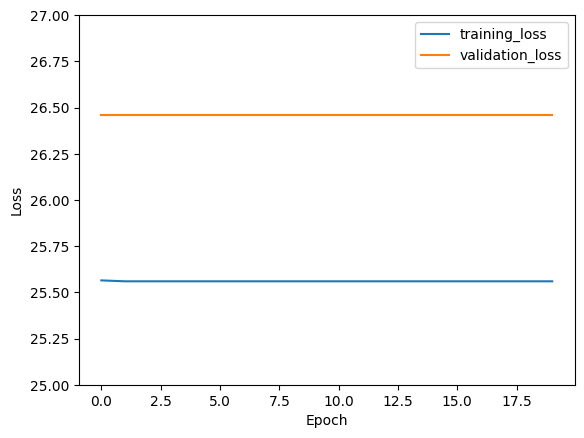

In [56]:

plot_learning_curve_loss(history)


In [58]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([26, 27])
    plt.legend(loc='upper right')


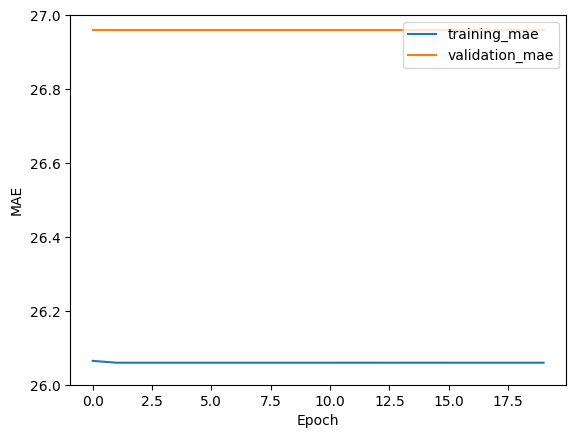

In [59]:

plot_learning_curve_metric(history)



## using tf.keras.optimizers.schedules.ExponentialDecay
initial_learning_rate = 1e-6
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=0.9,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD()
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

window_size = 30
batch_size = 32
n_splits = 3



In [66]:

history


{'loss': [3.8299951553344727,
  3.4111664295196533,
  3.4111173152923584,
  3.4111177921295166,
  3.4111180305480957,
  3.4111177921295166,
  3.4111173152923584,
  3.4111173152923584,
  3.411118507385254,
  3.411116600036621,
  3.4111180305480957,
  3.4111180305480957,
  3.4111177921295166,
  3.4111177921295166,
  3.4111173152923584,
  3.4111173152923584,
  3.4111173152923584,
  3.4111173152923584,
  3.4111180305480957,
  3.4111173152923584],
 'mae': [4.3112263679504395,
  3.889801025390625,
  3.88975191116333,
  3.8897526264190674,
  3.889751434326172,
  3.88975191116333,
  3.88975191116333,
  3.8897531032562256,
  3.8897511959075928,
  3.8897526264190674,
  3.88975191116333,
  3.8897511959075928,
  3.889751434326172,
  3.8897511959075928,
  3.88975191116333,
  3.8897523880004883,
  3.8897523880004883,
  3.889751434326172,
  3.8897523880004883,
  3.8897523880004883],
 'val_loss': [3.164767026901245,
  3.16426157951355,
  3.16426157951355,
  3.16426157951355,
  3.16426157951355,
  3.16

In [67]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([3, 4])
    plt.legend(loc='upper right')
    plt.show()


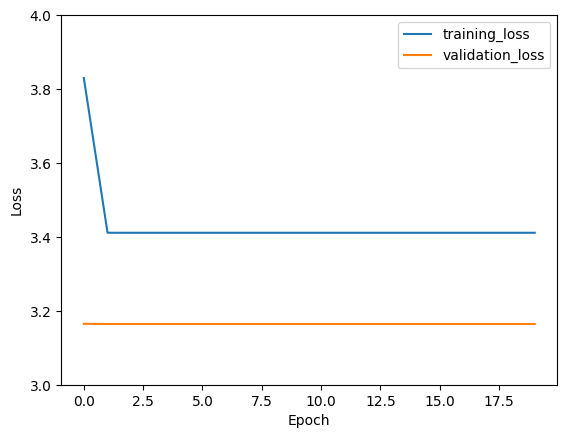

In [68]:

plot_learning_curve_loss(history)


In [69]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([3, 5])
    plt.legend(loc='upper right')



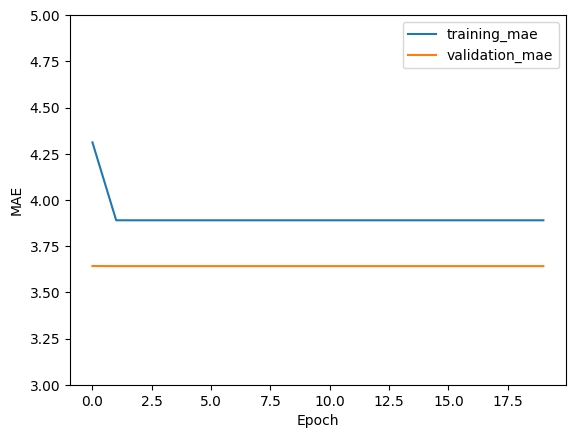

In [70]:

plot_learning_curve_metric(history)



## Changed the initial_learning_rate, decay_steps, and decay_rate in tf.keras.optimizers.schedules.ExponentialDecay

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.5,
    staircase=False)# Set to False for smooth decay, True for stepwise decay


In [82]:

history


{'loss': [6.103293418884277,
  1.7452141046524048,
  1.745209813117981,
  1.7452101707458496,
  1.74521005153656,
  1.74521005153656,
  1.745209813117981,
  1.74521005153656,
  1.74521005153656,
  1.74521005153656,
  1.7452095746994019,
  1.74521005153656,
  1.7452101707458496,
  1.7452104091644287,
  1.7452095746994019,
  1.74521005153656,
  1.7452104091644287,
  1.745209813117981,
  1.74521005153656,
  1.745209813117981],
 'mae': [6.562547206878662,
  2.1952176094055176,
  2.1952121257781982,
  2.1952126026153564,
  2.1952126026153564,
  2.1952133178710938,
  2.1952126026153564,
  2.1952123641967773,
  2.1952121257781982,
  2.1952130794525146,
  2.1952128410339355,
  2.1952126026153564,
  2.1952128410339355,
  2.1952123641967773,
  2.1952133178710938,
  2.1952130794525146,
  2.1952128410339355,
  2.1952133178710938,
  2.1952126026153564,
  2.1952123641967773],
 'val_loss': [1.6810652017593384,
  1.681042194366455,
  1.681042194366455,
  1.681042194366455,
  1.681042194366455,
  1.681

In [85]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 6])
    plt.legend(loc='upper right')
    plt.show()


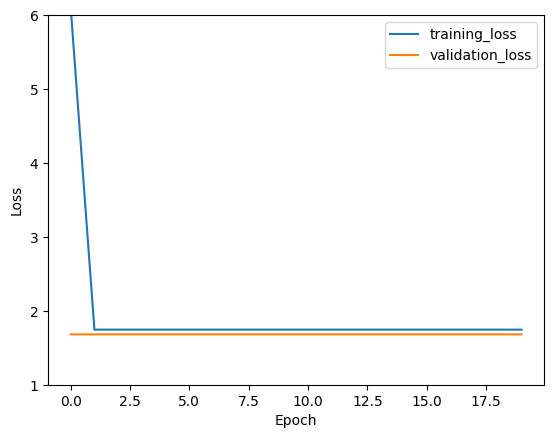

In [86]:
plot_learning_curve_loss(history)


## Changing tf.keras.optimizers.schedules.ExponentialDecay with the following values
window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50,
    decay_rate=0.85,
    staircase=False)# Set to False for smooth decay, True for stepwise decay
    

In [94]:

history


{'loss': [16.846176147460938,
  4.815208435058594,
  3.0696916580200195,
  2.0744121074676514,
  1.7525838613510132,
  1.7093852758407593,
  1.6796892881393433,
  1.6695770025253296,
  1.6608065366744995,
  1.6502087116241455,
  1.6369417905807495,
  1.6380974054336548,
  1.6366245746612549,
  1.6317051649093628,
  1.627358078956604,
  1.6269694566726685,
  1.6250799894332886,
  1.6238176822662354,
  1.6235851049423218,
  1.62261164188385],
 'mae': [17.34380340576172,
  5.303539752960205,
  3.543550491333008,
  2.532846450805664,
  2.2019593715667725,
  2.1582891941070557,
  2.1279361248016357,
  2.117804765701294,
  2.1078827381134033,
  2.1009788513183594,
  2.0844197273254395,
  2.087547540664673,
  2.0874195098876953,
  2.0792553424835205,
  2.0753612518310547,
  2.075305461883545,
  2.073469400405884,
  2.07192325592041,
  2.07222843170166,
  2.0710220336914062],
 'val_loss': [9.47559642791748,
  3.956477403640747,
  2.9092037677764893,
  1.6364824771881104,
  1.5778659582138062,


In [116]:

del plot_learning_curve_loss, plot_learning_curve_metric
gc.collect()


137528

In [98]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 16])
    plt.legend(loc='upper right')
    plt.show()


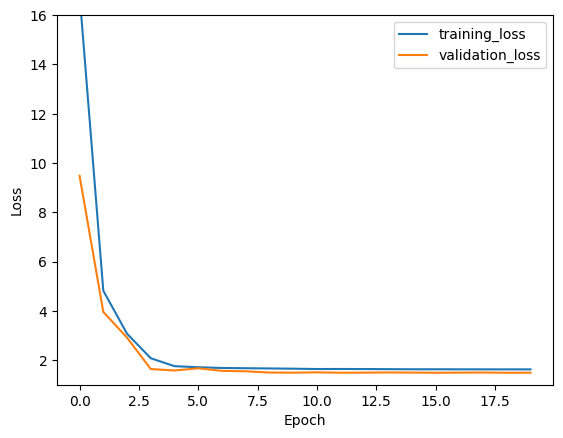

In [100]:

plot_learning_curve_loss(history)


In [101]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 17])
    plt.legend(loc='upper right')


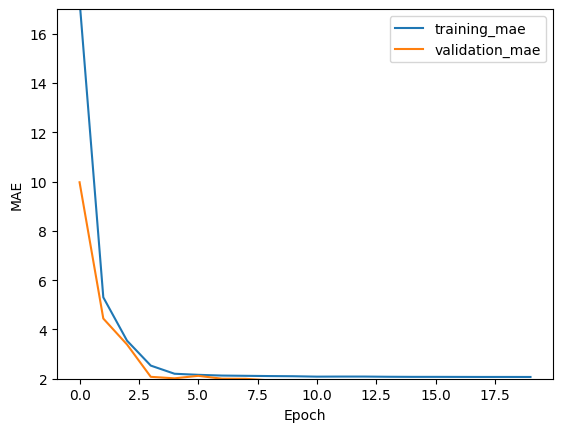

In [102]:

plot_learning_curve_metric(history)



## Tweaking tf.keras.optimizers.schedules.ExponentialDecay
window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay



In [110]:

history


{'loss': [8792.533203125,
  6514.59326171875,
  6120.6591796875,
  5589.9541015625,
  5282.5771484375,
  4794.18603515625,
  4308.81396484375,
  4065.416259765625,
  3713.86474609375,
  3503.045654296875,
  3210.27392578125,
  3026.27685546875,
  2767.27587890625,
  2614.569091796875,
  2376.615234375,
  2234.5712890625,
  2079.662353515625,
  1928.2772216796875,
  1795.1158447265625,
  1663.746337890625],
 'mae': [8793.033203125,
  6515.09326171875,
  6121.1591796875,
  5590.4541015625,
  5283.0771484375,
  4794.68603515625,
  4309.3134765625,
  4065.916259765625,
  3714.36474609375,
  3503.545166015625,
  3210.77392578125,
  3026.77685546875,
  2767.77587890625,
  2615.069091796875,
  2377.114990234375,
  2235.0712890625,
  2080.162353515625,
  1928.7772216796875,
  1795.6158447265625,
  1664.246337890625],
 'val_loss': [1658.0537109375,
  11513.66796875,
  626.5485229492188,
  10651.318359375,
  478.6379699707031,
  8817.4306640625,
  7594.6220703125,
  470.1764221191406,
  7021.743

In [112]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([500, 9000])
    plt.legend(loc='upper right')
    plt.show()


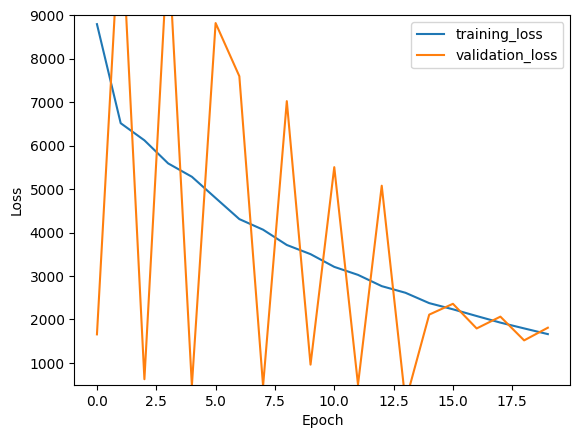

In [113]:

plot_learning_curve_loss(history)


In [114]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([500, 9000])
    plt.legend(loc='upper right')


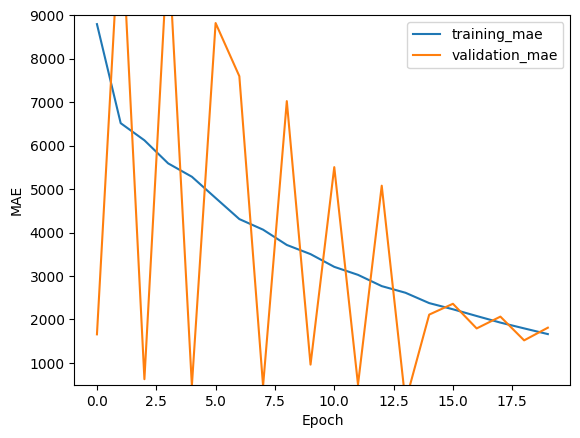

In [115]:

plot_learning_curve_metric(history)



## Tweaking tf.keras.optimizers.schedules.ExponentialDecay with the following setup

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay


model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [123]:

history


{'loss': [16.482797622680664,
  5.819845199584961,
  4.421970367431641,
  3.708770751953125,
  3.1952505111694336,
  2.9860098361968994,
  2.16084885597229,
  2.1681041717529297,
  2.0634965896606445,
  1.9536126852035522,
  1.8546009063720703,
  1.7670549154281616,
  1.7563852071762085,
  1.7371913194656372,
  1.6960270404815674,
  1.6937029361724854,
  1.6588274240493774,
  1.6589421033859253,
  1.6374629735946655,
  1.6389234066009521],
 'mae': [16.981416702270508,
  6.311757564544678,
  4.9101881980896,
  4.1890645027160645,
  3.67118763923645,
  3.4627134799957275,
  2.6189348697662354,
  2.6242833137512207,
  2.521237373352051,
  2.4122235774993896,
  2.3090617656707764,
  2.215216636657715,
  2.2034995555877686,
  2.1874208450317383,
  2.140587329864502,
  2.1403305530548096,
  2.1063568592071533,
  2.111050844192505,
  2.0841400623321533,
  2.0847132205963135],
 'val_loss': [5.420890808105469,
  5.071177005767822,
  4.33246374130249,
  4.053748607635498,
  2.7685866355895996,
 

In [126]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 8])
    plt.legend(loc='upper right')
    plt.show()


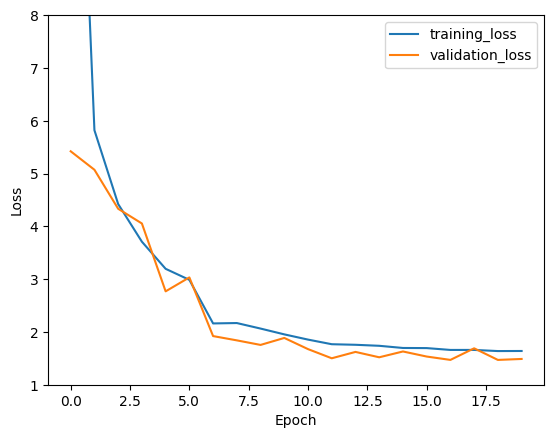

In [127]:

plot_learning_curve_loss(history)


In [128]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([1, 8])
    plt.legend(loc='upper right')



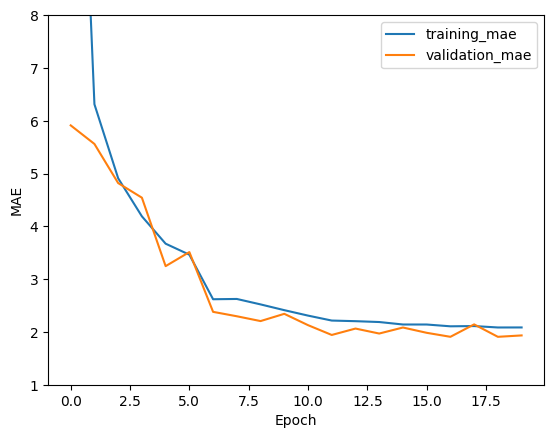

In [129]:

plot_learning_curve_metric(history)



## Tweaking tf.keras.optimizers.schedules.ExponentialDecay with the following setup. Primarily changed the batch_size

window_size = 30
batch_size = 64
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [138]:

history


{'loss': [23.01702308654785,
  8.165606498718262,
  6.016104221343994,
  4.793389797210693,
  4.336103916168213,
  3.9882113933563232,
  3.5043673515319824,
  3.5065622329711914,
  3.175377607345581,
  3.1602752208709717,
  3.0943408012390137,
  2.6352484226226807,
  2.396146297454834,
  2.318390369415283,
  2.1377034187316895,
  1.9835755825042725,
  2.0252790451049805,
  1.8048511743545532,
  1.7883350849151611,
  1.9553848505020142],
 'mae': [23.51613998413086,
  8.661614418029785,
  6.507750511169434,
  5.280047416687012,
  4.818270683288574,
  4.470268249511719,
  3.983030319213867,
  3.984912872314453,
  3.6527786254882812,
  3.6355648040771484,
  3.570345401763916,
  3.102971315383911,
  2.860499620437622,
  2.777548313140869,
  2.6002285480499268,
  2.436765193939209,
  2.4846744537353516,
  2.2552413940429688,
  2.238579034805298,
  2.4105782508850098],
 'val_loss': [10.615336418151855,
  7.235428810119629,
  5.867428302764893,
  6.505778789520264,
  2.597517251968384,
  4.380

In [143]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 12])
    plt.legend(loc='upper right')
    plt.show()



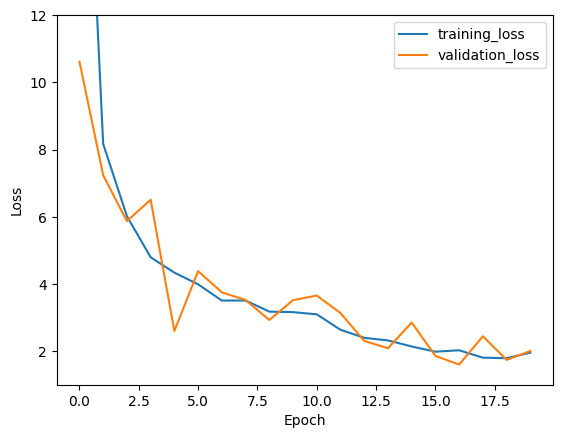

In [144]:

plot_learning_curve_loss(history)


In [145]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 13])
    plt.legend(loc='upper right')



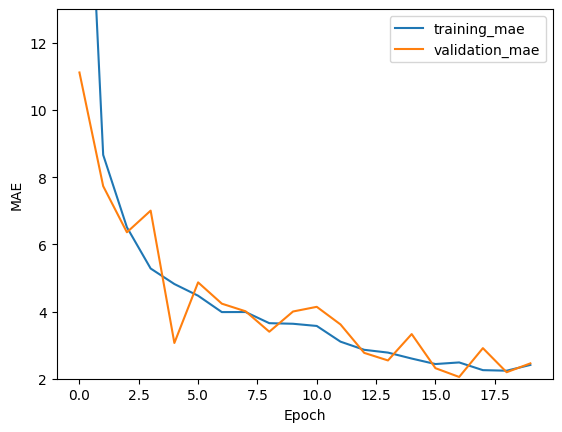

In [146]:

plot_learning_curve_metric(history)



## 
window_size = 30
batch_size = 64
n_splits = 3


initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    

In [154]:

history


{'loss': [19.924827575683594,
  14.014558792114258,
  13.357377052307129,
  12.81462574005127,
  12.348572731018066,
  12.064659118652344,
  11.575407981872559,
  11.030695915222168,
  10.693964958190918,
  10.121660232543945,
  9.720911979675293,
  9.263872146606445,
  8.953605651855469,
  8.609689712524414,
  8.118701934814453,
  7.926565647125244,
  7.544003486633301,
  7.132724761962891,
  6.733911514282227,
  6.361836910247803],
 'mae': [20.42409324645996,
  14.514532089233398,
  13.857352256774902,
  13.314592361450195,
  12.848271369934082,
  12.56459903717041,
  12.075163841247559,
  11.530200004577637,
  11.19332504272461,
  10.621023178100586,
  10.219988822937012,
  9.762490272521973,
  9.45132064819336,
  9.107796669006348,
  8.61546516418457,
  8.424144744873047,
  8.040345191955566,
  7.6285905838012695,
  7.229127883911133,
  6.855590343475342],
 'val_loss': [17.674585342407227,
  16.28860855102539,
  14.12240982055664,
  13.149415969848633,
  13.589859008789062,
  12.93

In [155]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([6, 20])
    plt.legend(loc='upper right')
    plt.show()


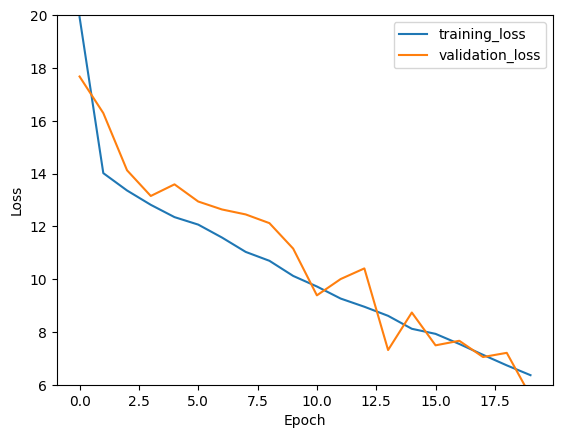

In [156]:

plot_learning_curve_loss(history)


In [157]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([6, 21])
    plt.legend(loc='upper right')


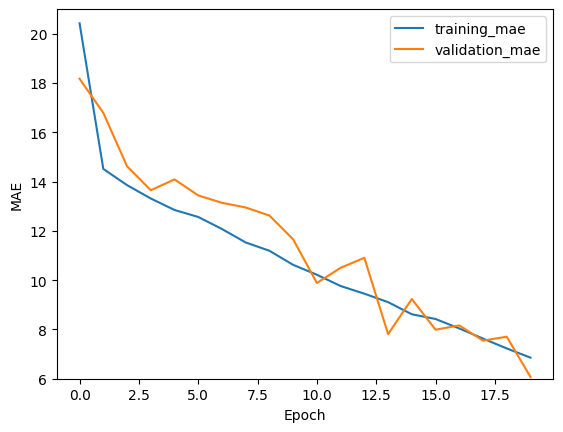

In [158]:

plot_learning_curve_metric(history)



## Following setup

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])



In [165]:

history


{'loss': [14.835350036621094,
  9.371881484985352,
  8.56116008758545,
  7.188684463500977,
  6.402353286743164,
  5.448160648345947,
  5.83566951751709,
  5.099391937255859,
  4.829748153686523,
  4.837319374084473,
  4.453280448913574,
  3.7923526763916016,
  3.562373161315918,
  2.9674272537231445,
  2.5821144580841064,
  2.3983702659606934,
  2.0621724128723145,
  1.9816370010375977,
  1.9840515851974487,
  1.894814133644104],
 'mae': [15.331710815429688,
  9.864775657653809,
  9.052977561950684,
  7.676916122436523,
  6.886931896209717,
  5.931300163269043,
  6.322147846221924,
  5.5842437744140625,
  5.31458044052124,
  5.325677394866943,
  4.939985752105713,
  4.270964622497559,
  4.042007923126221,
  3.441586494445801,
  3.046704053878784,
  2.8637514114379883,
  2.51796293258667,
  2.43452525138855,
  2.4379448890686035,
  2.3503518104553223],
 'val_loss': [7.520563125610352,
  10.69759464263916,
  11.109670639038086,
  5.686752796173096,
  5.054995536804199,
  5.1085357666015

In [166]:

del plot_learning_curve_loss, plot_learning_curve_metric


In [167]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([1, 15])
    plt.legend(loc='upper right')


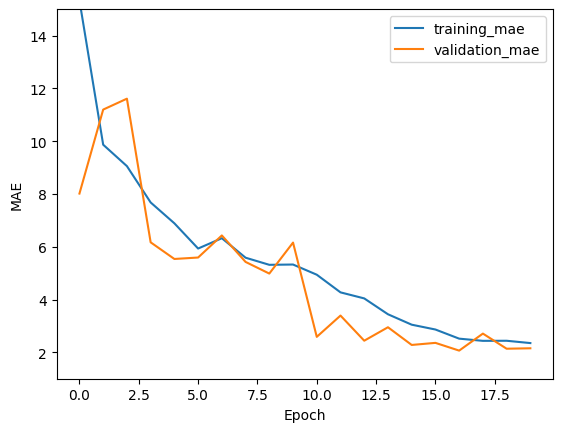

In [168]:

plot_learning_curve_metric(history)


In [169]:

repeated plot_learning_curve_metric twice
def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 16])
    plt.legend(loc='upper right')


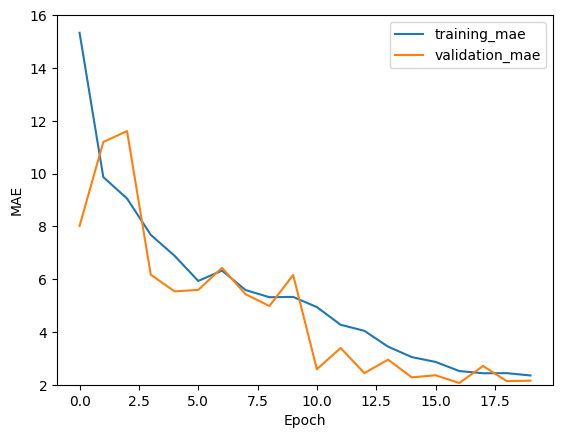

In [170]:

plot_learning_curve_metric(history)



## with the following setup

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

window_size = 30
batch_size = 32
n_splits = 3

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=55,
    decay_rate=0.95,
    staircase=False)# Set to False for smooth decay, True for stepwise decay




In [177]:

history


{'loss': [20.408231735229492,
  11.027413368225098,
  10.447242736816406,
  9.513200759887695,
  8.80674934387207,
  7.952630519866943,
  7.508314609527588,
  6.787930965423584,
  6.206376552581787,
  5.428271293640137,
  4.967269420623779,
  4.662245273590088,
  3.9216418266296387,
  3.58514666557312,
  3.248204469680786,
  2.716223955154419,
  2.6656174659729004,
  2.2490456104278564,
  2.30721378326416,
  2.234159469604492],
 'mae': [20.906028747558594,
  11.526968955993652,
  10.946864128112793,
  10.011837005615234,
  9.305341720581055,
  8.44982624053955,
  8.005720138549805,
  7.283973693847656,
  6.701895713806152,
  5.918585300445557,
  5.45698356628418,
  5.149880409240723,
  4.4025397300720215,
  4.06325626373291,
  3.7243144512176514,
  3.1843676567077637,
  3.1337990760803223,
  2.708650588989258,
  2.767880439758301,
  2.6920857429504395],
 'val_loss': [8.901129722595215,
  10.324592590332031,
  10.52920913696289,
  10.229209899902344,
  8.608893394470215,
  7.88667154312

In [178]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 21])
    plt.legend(loc='upper right')


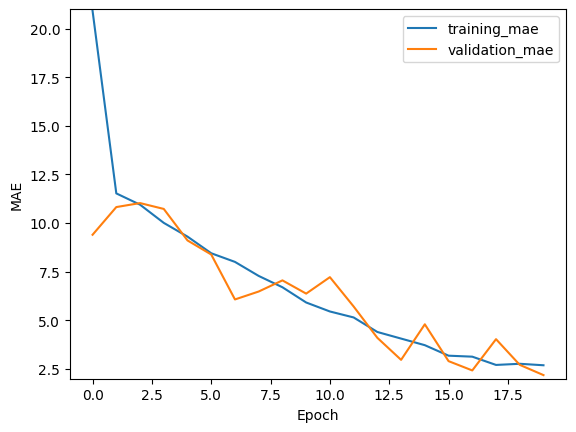

In [179]:
plot_learning_curve_metric(history)

In [180]:

repeated plot_learning_curve_metric twice
def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 21])
    plt.legend(loc='upper right')


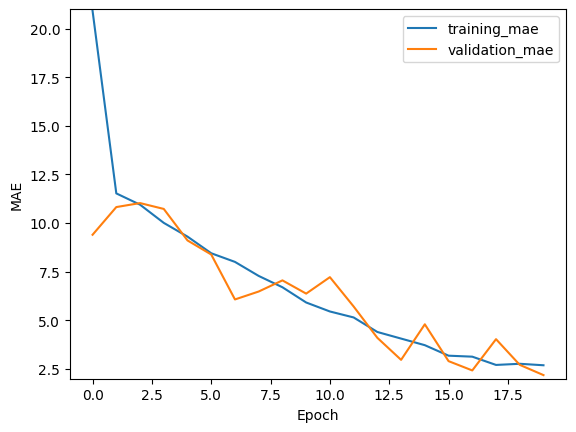

In [181]:
plot_learning_curve_metric(history)


## Tweaking with the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * tf.math.exp(epoch/10))

model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])



In [217]:

history


{'fold_1': {'loss': [38.99846649169922,
   27.46279525756836,
   15.601017951965332,
   5.933012008666992,
   3.969247817993164,
   3.5944440364837646,
   3.2412209510803223,
   2.9541471004486084,
   2.7312798500061035,
   2.5837178230285645,
   2.455566644668579,
   2.3553764820098877,
   2.280100107192993,
   2.2437620162963867,
   2.2024667263031006,
   2.188253402709961,
   2.1711795330047607,
   2.138495683670044,
   2.1005373001098633,
   2.0888776779174805],
  'mae': [39.49846649169922,
   27.96279525756836,
   16.10010528564453,
   6.412848472595215,
   4.445356369018555,
   4.0712666511535645,
   3.714548349380493,
   3.4252939224243164,
   3.2024431228637695,
   3.0488200187683105,
   2.9171533584594727,
   2.8125295639038086,
   2.7387001514434814,
   2.700547218322754,
   2.659728765487671,
   2.6415624618530273,
   2.6269052028656006,
   2.594111442565918,
   2.5575473308563232,
   2.5429093837738037],
  'val_loss': [31.1641845703125,
   19.437355041503906,
   7.888880729

In [234]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 4])
    plt.legend(loc='upper right')
    plt.show()



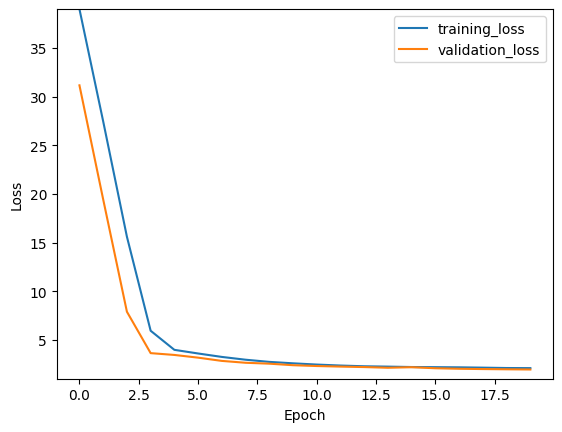

In [226]:

plot_learning_curve_loss(history['fold_1'])


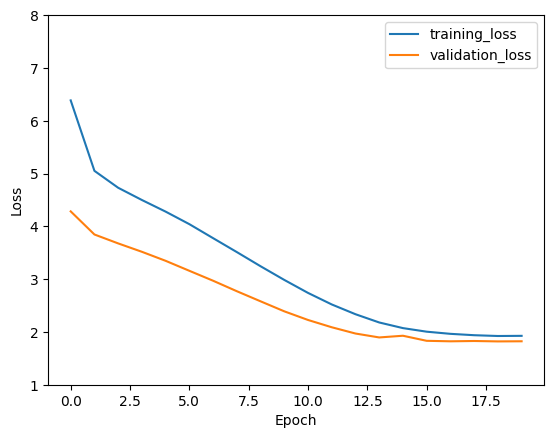

In [231]:

plot_learning_curve_loss(history['fold_2'])


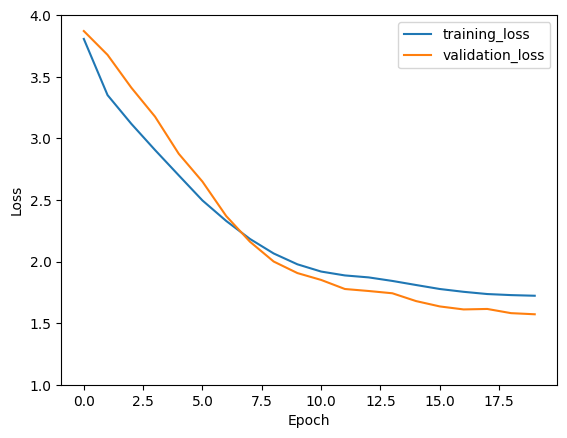

In [235]:

plot_learning_curve_loss(history['fold_3'])



## Tweaking with the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3* tf.math.exp(epoch/20))
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-6, momentum=0.3)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [245]:

history


{'fold_1': {'loss': [30.673904418945312,
   8.115432739257812,
   8.61119270324707,
   8.930864334106445,
   11.100785255432129,
   12.360068321228027,
   13.072107315063477,
   13.519549369812012,
   14.271403312683105,
   14.92193603515625,
   16.134977340698242,
   16.648542404174805,
   17.913040161132812,
   18.729568481445312,
   19.930126190185547,
   20.43922996520996,
   21.353857040405273,
   22.764429092407227,
   24.11699867248535,
   25.331581115722656],
  'mae': [31.171772003173828,
   8.603787422180176,
   9.096864700317383,
   9.41929817199707,
   11.590815544128418,
   12.856938362121582,
   13.569724082946777,
   14.019549369812012,
   14.771092414855957,
   15.421540260314941,
   16.634977340698242,
   17.148128509521484,
   18.413042068481445,
   19.229568481445312,
   20.430126190185547,
   20.93886947631836,
   21.853532791137695,
   23.264427185058594,
   24.616989135742188,
   25.831581115722656],
  'val_loss': [19.587154388427734,
   13.611616134643555,
   5.21

In [250]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([14, 46])
    plt.legend(loc='upper right')
    plt.show()



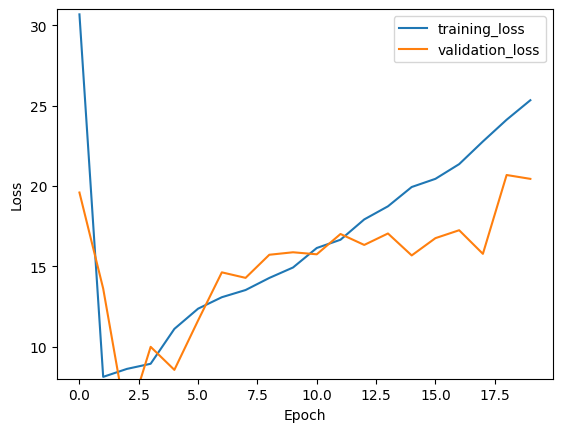

In [247]:
plot_learning_curve_loss(history['fold_1'])

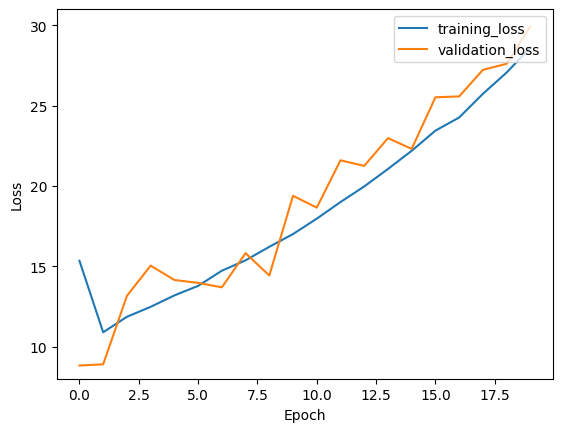

In [248]:

plot_learning_curve_loss(history['fold_2'])


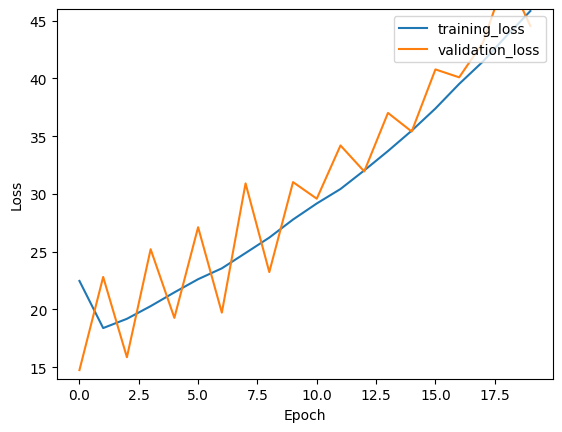

In [251]:

plot_learning_curve_loss(history['fold_3'])



## Tweaking with the following setup

window_size = 30
batch_size = 32
n_splits = 3

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6* tf.math.exp(epoch/20))
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



In [262]:

history


{'fold_1': {'loss': [8.939382553100586,
   3.158550977706909,
   2.7313232421875,
   2.673558473587036,
   2.6389734745025635,
   2.6026220321655273,
   2.584420919418335,
   2.5551912784576416,
   2.5351741313934326,
   2.5200302600860596,
   2.5005078315734863,
   2.4872384071350098,
   2.497044801712036,
   2.4549784660339355,
   2.4474785327911377,
   2.426459789276123,
   2.402377128601074,
   2.3769819736480713,
   2.3533530235290527,
   2.31630539894104],
  'mae': [9.431398391723633,
   3.626544237136841,
   3.1901915073394775,
   3.1309428215026855,
   3.098466634750366,
   3.066253185272217,
   3.0438449382781982,
   3.0145022869110107,
   2.9962239265441895,
   2.97556471824646,
   2.9576456546783447,
   2.9482083320617676,
   2.9552016258239746,
   2.912362813949585,
   2.903848886489868,
   2.88303542137146,
   2.855905294418335,
   2.832495927810669,
   2.809725761413574,
   2.7681546211242676],
  'val_loss': [3.2464241981506348,
   2.532975912094116,
   2.5284006595611572

In [270]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 9])
    plt.legend(loc='upper right')
    plt.show()


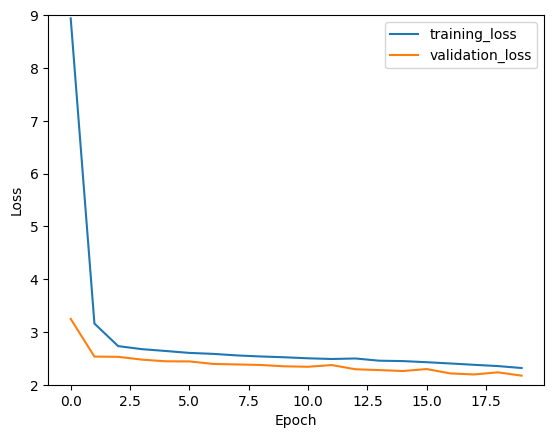

In [264]:

plot_learning_curve_loss(history['fold_1'])


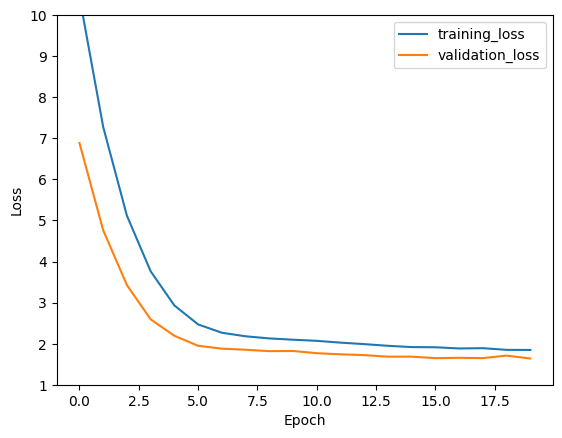

In [267]:

plot_learning_curve_loss(history['fold_2'])


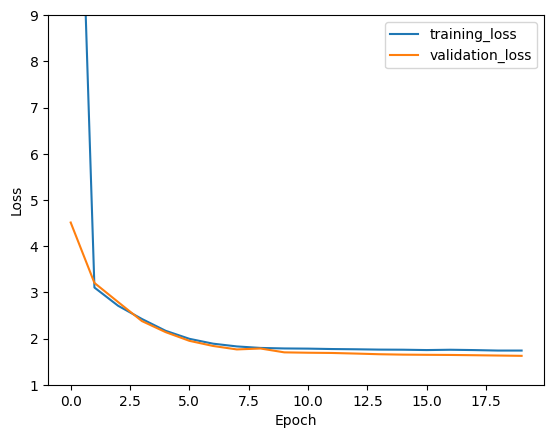

In [271]:

plot_learning_curve_loss(history['fold_3'])


In [272]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([2, 10])
    plt.legend(loc='upper right')


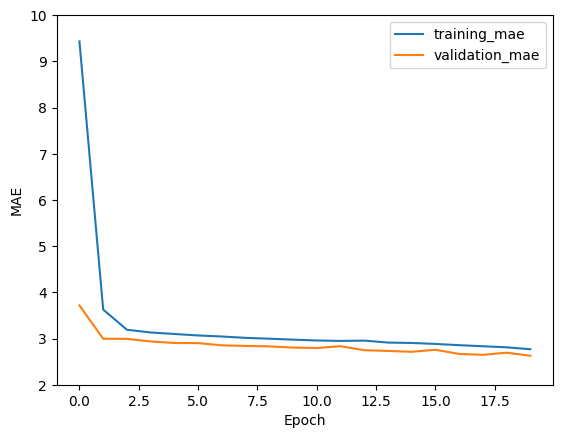

In [273]:
plot_learning_curve_metric(history['fold_1'])

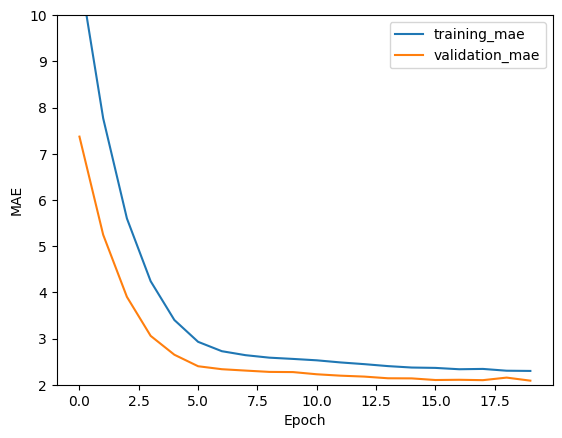

In [274]:

plot_learning_curve_metric(history['fold_2'])


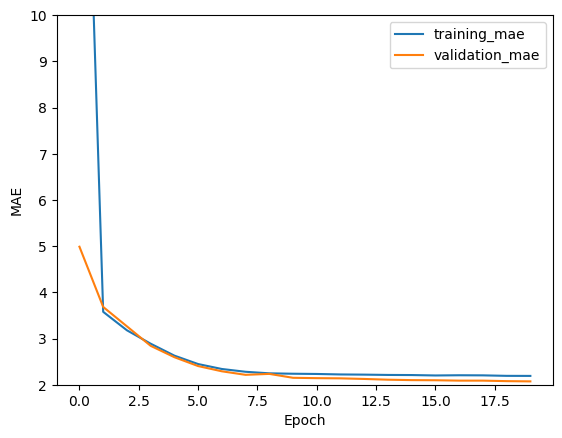

In [275]:

plot_learning_curve_metric(history['fold_3'])


In [277]:

del plot_learning_curve_metric, plot_learning_curve_loss, history


In [280]:

gc.collect()


0

In [281]:

from tensorflow.keras.backend import clear_session
clear_session()
